In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/companypolicies/company_policy.txt


# Installing Required Libraries for Model and Data Processing

In [39]:
# Install required libraries for transformer-based models, datasets, and PyTorch (for deep learning)
!pip install --user transformers datasets torch faiss-cpu 

# Install additional libraries for data visualization and machine learning
!pip install --user matplotlib scikit-learn 

# Install FAISS with GPU support for efficient similarity search and clustering
!pip install faiss-gpu


# Import Libraries

In [40]:
# Importing required libraries
# 'wget' is commented out, but you can use it to download files from URLs if needed
# import wget  

# Importing transformers for working with the Dense Retriever (DPR) model
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer  # For encoding context using DPR
import torch  # PyTorch for deep learning models

# Importing additional libraries for randomization and number operations
import numpy as np  # For numerical operations with arrays
import random  # For generating random numbers

# Importing question encoding modules from HuggingFace's transformers library
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer  # For encoding questions using DPR

# Importing AutoTokenizer and AutoModel for pre-trained causal language model (e.g., GPT-2 or GPT-3)
from transformers import AutoTokenizer, AutoModelForCausalLM  # For text generation models (causal LM)

# Importing libraries for 3D plotting and dimensionality reduction
import matplotlib.pyplot as plt  # For plotting graphs (used for visualizations)
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting support in matplotlib

# Importing t-SNE for dimensionality reduction (commonly used for visualizing high-dimensional data)
from sklearn.manifold import TSNE  # For dimensionality reduction to visualize high-dimensional data

# Importing numpy again (redundant as it's already imported) – this could be removed
import numpy as np  # For numerical operations (again, already imported)

# Function to suppress warnings during execution
def warn(*args, **kwargs):
    pass  # This function does nothing, effectively suppressing warnings

# Reassigning 'warnings.warn' to suppress all warnings
import warnings  # Import warnings module
warnings.warn = warn  # Override the default 'warn' function to suppress warnings
warnings.filterwarnings('ignore')  # Ignore all warnings in the output


# Text Processing, Tokenization

In [41]:
def read_and_split_text(filename):
    """
    Reads a text file and splits it into non-empty paragraphs.
    
    Args:
    - filename (str): The path to the text file to be read.
    
    Returns:
    - list: A list of non-empty paragraphs from the file.
    """
    # Open the file and read its content
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Split the text by newlines and filter out empty paragraphs
    paragraphs = [para.strip() for para in text.split('\n') if para.strip()]
    
    return paragraphs


# Define the file path
file_path = '/kaggle/input/companypolicies/company_policy.txt'

# Read the file and get the paragraphs
paragraphs = read_and_split_text(file_path)

# Display the first 10 paragraphs (for preview)
paragraphs[:10]


['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [74]:
# Loop through the first 4 paragraphs and print them with an index
for i in range(4):
    # Print the index and corresponding paragraph with clear formatting
    print(f"Sample {i}: {paragraphs[i]}\n")  # Display paragraph with its index


Sample 0: Treatment and Assistance: Employees with substance abuse issues are encouraged to seek help. The organization is committed to providing support, resources, and information to assist those seeking treatment.

Sample 1: Cost Management: Keep personal phone usage separate from company accounts and reimburse the company for any personal charges on company-issued phones.

Sample 2: Security: Safeguard your mobile device and access credentials. Exercise caution when downloading apps or clicking links from unfamiliar sources. Promptly report security concerns or suspicious activities related to your mobile device.

Sample 3: Harassment: Harassment in any form, whether based on the aforementioned characteristics or any other protected status, is unacceptable. This encompasses unwelcome advances, offensive jokes, slurs, and other verbal or physical conduct that creates a hostile or intimidating work environment.



In [83]:
%%capture
# Load the DPR (Dense Passage Retriever) context tokenizer for a pre-trained model
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
# Display the tokenizer object (this won't be shown due to %%capture)
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [87]:
# Define a list of tuples with question-answer pairs
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]

# Print the list of question-answer pairs
print(text)

# Tokenize the input text using the context tokenizer, 
# with padding, truncation, and a maximum length of 256 tokens.
tokens_info = context_tokenizer(
    text, 
    return_tensors='pt',  # Return PyTorch tensors for model input
    padding=True,  # Pad sequences to the longest one in the batch
    truncation=True,  # Truncate sequences longer than max_length
    max_length=256  # Maximum sequence length of 256 tokens
)

# Display the tokenized information (input IDs and attention masks)
tokens_info

# Iterate over each tokenized input and convert its ID back to tokens
for s in tokens_info['input_ids']:
    # Convert token IDs to readable tokens and print them
    print(context_tokenizer.convert_ids_to_tokens(s))

# Load the pre-trained DPR (Dense Passage Retrieval) context encoder model
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')


[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]
['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [95]:
# Shuffle the samples randomly to ensure they are not ordered based on their category
# This helps prevent any bias during processing that could arise from an ordered dataset
random.shuffle(paragraphs)

# Tokenize the first 20 shuffled paragraphs for input into the model
# The tokenization process includes padding, truncating to a maximum length of 256 tokens
tokens = context_tokenizer(paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)

# Display the tokenized output (in tensor format) for the first 20 paragraphs
tokens

# Pass the tokenized input through the context encoder to generate embeddings for the paragraphs
# The encoder processes the tokenized input and returns the corresponding embeddings
outputs = context_encoder(**tokens)

# Extract the pooler_output (the representation of the entire text) from the encoder output
# This output is typically used as the fixed-size representation of each paragraph
outputs.pooler_output


tensor([[ 0.3869,  0.4322,  0.3379,  ..., -0.4071, -0.0797, -0.0184],
        [ 0.3005,  0.5121, -0.1547,  ..., -0.7096, -0.9071,  0.2282],
        [ 0.2214,  0.3090, -0.3535,  ..., -0.4585, -0.9006, -0.1875],
        ...,
        [ 0.1780,  0.5352,  0.5585,  ..., -0.6085, -0.8304, -0.1766],
        [ 0.4561,  0.3122,  0.1356,  ..., -0.2938, -0.4350,  0.0328],
        [ 0.6020,  0.3124,  0.0835,  ..., -0.5222, -0.2321,  0.2006]],
       grad_fn=<SliceBackward0>)

In [50]:
#tsne_plot(outputs.pooler_output.detach().numpy())

## Embedding Generation, and t-SNE Visualization of Contexts

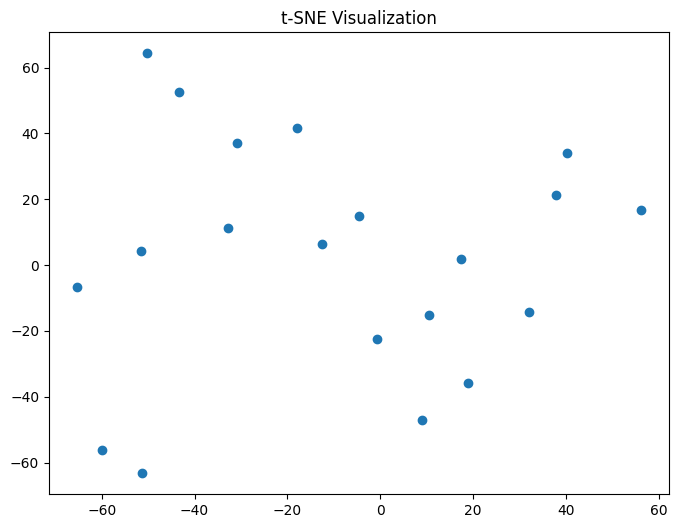

In [89]:
# Import necessary libraries for visualization and dimensionality reduction
import matplotlib.pyplot as plt  # For plotting scatter plots
from sklearn.manifold import TSNE  # For performing t-SNE (t-Distributed Stochastic Neighbor Embedding) for dimensionality reduction

# Assuming `outputs.pooler_output` is the tensor containing the embeddings you want to visualize
# Detach the tensor from the computation graph and convert it to a NumPy array for further processing
embeddings = outputs.pooler_output.detach().numpy()

# Perform t-SNE transformation to reduce dimensionality to 2D for visualization
# n_components=2 specifies that we want to reduce the embeddings to 2D
# perplexity is a hyperparameter that affects the balance between local and global aspects of the data
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings)

# Create a scatter plot of the 2D reduced embeddings
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])  # Plot the 2D points
plt.title("t-SNE Visualization")  # Add a title to the plot
plt.show()  # Display the plot


In [54]:
# Initialize an empty list to store the embeddings of the text samples
embeddings = []

# Iterate through the first 5 paragraphs to generate embeddings
for text in paragraphs[0:5]:
    # Tokenize each text using the context tokenizer
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    
    # Pass the tokenized inputs through the context encoder to generate the embedding
    outputs = context_encoder(**inputs)
    
    # Append the pooler_output (embedding) to the embeddings list
    embeddings.append(outputs.pooler_output)
    
    # Print the number of samples processed so far
    print("Number of samples processed:")
    print(len(embeddings))  # Length of embeddings list represents the number of processed samples
    
    # Print the shape of the latest embedding (pooler_output)
    print("Shape of the embedding for the current sample:")
    print(outputs.pooler_output.shape)  # Output shape of the current sample's embedding


number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [55]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

#  FAISS Indexing, and Retrieval for Question-Context Matching

In [94]:
def encode_contexts(text_list):
    """
    Encodes a list of text passages into embeddings using a pre-trained context encoder.

    Args:
    - text_list (list): A list of text passages (e.g., paragraphs) to be encoded.

    Returns:
    - numpy.ndarray: The concatenated embeddings for all input texts.
    """
    embeddings = []  # Initialize an empty list to store the embeddings
    
    # Loop through each text in the provided list
    for text in text_list:
        # Tokenize the text to prepare it for the context encoder
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        
        # Pass the tokenized inputs through the context encoder to get the embeddings
        outputs = context_encoder(**inputs)
        
        # Extract the pooler output (final representation of the text) and append it to the embeddings list
        embeddings.append(outputs.pooler_output)
    
    # Concatenate all embeddings into a single tensor, detach from computation graph, and convert to NumPy array
    return torch.cat(embeddings).detach().numpy()


# Encode the paragraphs into embeddings
# The `paragraphs` list contains the text data you want to encode.
context_embeddings = encode_contexts(paragraphs)


In [58]:
# Import the FAISS library, which is used for efficient similarity search
import faiss

# Set the dimension of the embeddings
embedding_dim = 768  # This should match the dimension of your embeddings (e.g., for BERT-based embeddings)

# Convert the list of context embeddings into a single NumPy array and ensure it's in float32 format
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for performing fast similarity search using L2 (Euclidean) distance
# IndexFlatL2 is a basic FAISS index that computes the L2 distance between vectors
index = faiss.IndexFlatL2(embedding_dim)

# Add the context embeddings to the FAISS index for future search operations
index.add(context_embeddings_np)


In [59]:
# Load the pre-trained DPR (Dense Passage Retrieval) question encoder and tokenizer
# These are used for encoding questions and tokenizing them to prepare for retrieval tasks

# Load the question encoder model from the HuggingFace library
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

# Load the tokenizer for the question encoder, which tokenizes the input question text
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [93]:
# Define the example question for which we want to find relevant contexts
question = 'Drug and Alcohol Policy'

# Tokenize the question using the pre-defined tokenizer for the question
question_inputs = question_tokenizer(question, return_tensors='pt')

# Generate the embedding for the question using the question encoder
# .pooler_output gives the pooled output representation of the question
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index for the top 5 most relevant contexts based on the question embedding
D, I = index.search(question_embedding, k=5)  # D: distances, I: indices of the top 5 contexts

# Print the distances and indices of the top 5 retrieved contexts
print("Distances (D):", D)
print("Indices (I):", I)


Distances (D): [[72.76532 74.71617 84.38807 88.36439 90.28715]]
Indices (I): [[74 38 12  7 24]]


In [61]:
# Print the top 5 relevant contexts retrieved based on the search

print("Top 5 relevant contexts:")

# Iterate over the indices of the top 5 contexts (I[0]) and their corresponding distances (D[0])
for i, idx in enumerate(I[0]):
    # Print the index (i+1) and the corresponding paragraph from the paragraphs list
    print(f"{i+1}: {paragraphs[idx]}")
    
    # Print the distance associated with the context to show its relevance
    print(f"Distance: {D[0][i]}\n")  # D[0][i] represents the distance for the i-th context


Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76531982421875

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71617126464844

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38806915283203

4: 9.	Discipline and Termination Policy
distance 88.36438751220703

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28714752197266



# Question-Context Retrieval and Text Generation Using Pre-trained Models

In [62]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

In [63]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [64]:
contexts= "What is a large language model?"

In [65]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [96]:
# Generate a summary or output based on the input tokens
# The `model.generate()` method generates text based on the input_ids from the tokenized input

summary_ids = model.generate(
    inputs['input_ids'],  # The tokenized input text
    max_length=50,        # Set the maximum length of the generated output to 50 tokens
    num_beams=4,          # Use beam search with 4 beams to generate more diverse and high-quality outputs
    early_stopping=True,  # Stop the generation early once a complete output is generated
    pad_token_id=tokenizer.eos_token_id  # Use the EOS (End of Sentence) token for padding during generation
)

# Output the generated token IDs
summary_ids


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [67]:
# Decode the generated token IDs back into a human-readable text
# The `summary_ids[0]` contains the tokenized output, and `skip_special_tokens=True` ensures that special tokens (like [CLS], [SEP]) are excluded from the decoded text
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the generated summary
print(summary)


What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


# Answer Generation with and without Context Using GPT-2 and Context Retrieval

In [68]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    
    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    
    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [69]:
# Example usage: Generating an answer for a given question without providing any context

# Define the question for which an answer is to be generated
question = "What is mobile policy?"

# Call the function to generate an answer without passing any context
answer = generate_answer_without_context(question)

# Print the generated answer
print("Answer:", answer)


Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


In [70]:
def generate_answer(question, contexts):
    """
    Generates an answer to the given question based on the provided contexts using GPT-2.
    
    Args:
    - question (str): The question for which the answer is to be generated.
    - contexts (list): A list of context passages that are relevant to the question.
    
    Returns:
    - str: The generated answer to the question.
    """
    # Concatenate the question with the contexts to form the complete input text for GPT-2
    input_text = question + ' ' + ' '.join(contexts)  # Combine question and contexts
    
    # Tokenize the input text for GPT-2 with truncation to fit the model's max length
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate an answer using GPT-2, controlling output length and other settings
    summary_ids = model.generate(
        inputs['input_ids'],                  # The tokenized input text
        max_new_tokens=50,                     # Limit the number of new tokens generated
        min_length=40,                         # Minimum length of the generated output
        length_penalty=2.0,                    # Penalty for longer sequences (discourages overly long answers)
        num_beams=4,                           # Beam search for better output quality (higher = more expensive)
        early_stopping=True,                   # Stop early when the model has generated a complete answer
        pad_token_id=tokenizer.eos_token_id    # Use the EOS token as padding
    )
    
    # Decode the generated token IDs into a human-readable string, skipping special tokens (like [CLS], [SEP])
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [92]:
# Define the question to be used in the search for relevant contexts
question = "What is mobile policy?"

# Perform a search to retrieve the top k relevant context paragraphs based on the question
# `search_relevant_contexts` returns two outputs: 
#   - The first output is ignored (`_`) 
#   - The second output `I` contains the indices of the top k relevant contexts
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

# Print the indices of the top k relevant paragraphs for the given question
print(f"Paragraph indices: {I}")


Paragraph indices: [[44 56 24 13  5]]


In [91]:
# Use the indices in I[0] to retrieve the top context paragraphs from the `paragraphs` list
# I[0] contains the indices of the most relevant context paragraphs based on some retrieval process.
top_contexts = [paragraphs[idx] for idx in I[0]]

# Print the top contexts that were retrieved for further inspection
print(f"Top contexts: {top_contexts}")


Top contexts: ['Disposal of Smoking Materials: Properly dispose of cigarette butts and related materials in designated receptacles. Littering on company premises is prohibited.', 'Feedback: Candidates will receive timely and constructive feedback on their application and interview performance.', 'Confidentiality: Avoid transmitting sensitive company information via unsecured messaging apps or emails. Be discreet when discussing company matters in public spaces.', 'Review and Update: This policy is subject to regular review and update to remain aligned with evolving legal requirements and best practices in preventing discrimination and harassment. This organization considers it a collective responsibility to ensure a workplace free from discrimination and harassment, and it is essential that every individual within the organization plays their part in upholding these principles.', 'Consequences: Non-compliance with this policy may lead to disciplinary actions, including the potential lo

In [90]:
# Assume `I[0]` contains indices of the top context passages retrieved for the given question
# These contexts will be used to generate the answer.

# Generate an answer based on the question and the top retrieved contexts
answer = generate_answer(question, top_contexts)

# Print the generated answer for the given question
print("Generated Answer:", answer)


Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta